# FX Benchmark Analysis

This notebook analyzes FX benchmark data collected from the Deluge.

## Prerequisites

1. Build with benchmarking: `./dbt configure -DENABLE_FX_BENCHMARK=ON -DENABLE_SYSEX_LOAD=YES && ./dbt build release`
2. Collect data: `./dbt fx-benchmark --collect -o fx_benchmark.csv`
3. Place `fx_benchmark.csv` in this directory or update the path below

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
CSV_PATH = "../../fx_benchmark.csv"  # Update path if needed
CPU_FREQ_HZ = 400_000_000  # 400 MHz Cortex-A9
SAMPLE_RATE = 44100
BUFFER_SIZE = 128  # SSI_TX_BUFFER_NUM_SAMPLES

# Calculate cycles per audio buffer at 100% CPU
CYCLES_PER_BUFFER = CPU_FREQ_HZ / SAMPLE_RATE * BUFFER_SIZE
print(f"CPU: {CPU_FREQ_HZ / 1e6:.0f} MHz")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Buffer size: {BUFFER_SIZE} samples")
print(f"Cycles per buffer (100% CPU): {CYCLES_PER_BUFFER:,.0f}")

CPU: 400 MHz
Sample rate: 44100 Hz
Buffer size: 128 samples
Cycles per buffer (100% CPU): 1,160,998


In [319]:
# Load benchmark data
df = pd.read_csv(CSV_PATH)

# Parse tags column (comma-separated)
df["tags_list"] = df["tags"].fillna("").apply(lambda x: x.split(",") if x else [])

print(f"Loaded {len(df)} samples")
print(f"Effects: {df['fx'].unique().tolist()}")
df.head()

Loaded 536 samples
Effects: ['srr_bitcrush', 'reverb_feather', 'filters']


,fx,cycles,ts,tags,tags_list
0,srr_bitcrush,94,-716965985,NaN,[]
1,reverb_feather,12451,-716959778,NaN,[]
2,filters,160,-716945764,NaN,[]
3,srr_bitcrush,41,-716945523,NaN,[]
4,srr_bitcrush,111,-338040688,NaN,[]


## Summary Statistics

In [320]:
# Filter to "total" entries for effects that have substage breakdown
# Effects with substages (setup/loop/total, crossover/envelope/recombine/total, etc.)
# should only use "total" rows in the main summary

# Known substage tag keywords (not "total")
SUBSTAGE_KEYWORDS = {
    # sine_shaper substages
    "setup",
    "loop",
    # multiband substages
    "crossover",
    "envelope",
    "recombine",
    # scatter substages
    "slice",
    "params",
    "paramread",
    "static",
    "envprep",
    "env",
    "pan",
    "delay",
    "record",
    "read",
    "advance",
}


def is_total_or_non_substage(row):
    """Return True if this row represents total DSP (not a substage)

    Logic:
    - If tags contain "total", include it (it's the total measurement)
    - If tags contain any known substage keyword, exclude it
    - Otherwise include (untagged or non-substage tags like reverb model, stage count)
    """
    tags = row["tags"] if pd.notna(row["tags"]) else ""
    tags_lower = tags.lower()

    # If "total" is present, it's the total measurement
    if "total" in tags_lower:
        return True

    # Check for any known substage keywords
    for kw in SUBSTAGE_KEYWORDS:
        if kw in tags_lower:
            return False

    # Not tagged as substage - include it
    return True


df_totals = df[df.apply(is_total_or_non_substage, axis=1)].copy()

print(f"Filtered to {len(df_totals)} total/non-substage samples (from {len(df)} total)")
print(f"Excluded substage keywords: {sorted(SUBSTAGE_KEYWORDS)}")

# Calculate summary statistics per effect using only totals
summary = df_totals.groupby("fx")["cycles"].agg(
    ["count", "mean", "std", "median", "min", "max"]
)

# Add CPU percentage column
summary["cpu_percent"] = (summary["mean"] / CYCLES_PER_BUFFER) * 100

# Format nicely
summary = summary.round(2)
summary = summary.sort_values("mean", ascending=False)

print("\nFX Benchmark Summary (sorted by mean cycles):")
print("=" * 80)
print(summary.to_string())
print("\nNote: cpu_percent is approximate load per audio buffer")
print("Note: Only 'total' tagged entries used for effects with substage breakdown")

Filtered to 536 total/non-substage samples (from 536 total)
Excluded substage keywords: ['advance', 'crossover', 'delay', 'env', 'envelope', 'envprep', 'loop', 'pan', 'paramread', 'params', 'read', 'recombine', 'record', 'setup', 'slice', 'static']

FX Benchmark Summary (sorted by mean cycles):
                count      mean      std  median   min    max  cpu_percent
fx                                                                        
reverb_feather    134  10081.84  2526.32  9818.0  5282  18852         0.87
filters           134    223.78   255.84   152.5   103   1116         0.02
srr_bitcrush      268     84.51    86.24    70.0    29   1032         0.01

Note: cpu_percent is approximate load per audio buffer
Note: Only 'total' tagged entries used for effects with substage breakdown


## Histograms by Effect

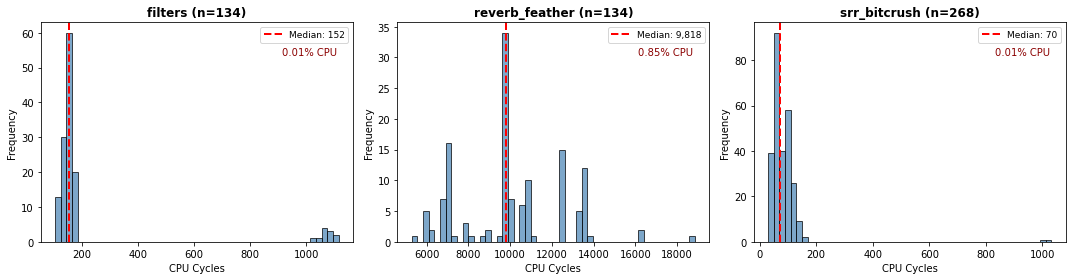

Saved: fx_benchmark_histograms.png


In [321]:
# Create histogram subplots for each effect (using totals only)
effects = df_totals["fx"].unique()
n_effects = len(effects)

# Calculate grid dimensions
n_cols = min(3, n_effects)
n_rows = (n_effects + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
if n_effects == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, fx_name in enumerate(sorted(effects)):
    ax = axes[idx]
    fx_data = df_totals[df_totals["fx"] == fx_name]["cycles"]

    # Histogram
    ax.hist(fx_data, bins=50, edgecolor="black", alpha=0.7, color="steelblue")

    # Add median line
    median_val = fx_data.median()
    ax.axvline(
        median_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Median: {median_val:,.0f}",
    )

    # Labels
    ax.set_title(f"{fx_name} (n={len(fx_data)})", fontsize=12, fontweight="bold")
    ax.set_xlabel("CPU Cycles")
    ax.set_ylabel("Frequency")
    ax.legend(loc="upper right", fontsize=9)

    # Add CPU percentage annotation
    cpu_pct = (median_val / CYCLES_PER_BUFFER) * 100
    ax.annotate(
        f"{cpu_pct:.2f}% CPU",
        xy=(0.95, 0.85),
        xycoords="axes fraction",
        ha="right",
        fontsize=10,
        color="darkred",
    )

# Hide unused subplots
for idx in range(n_effects, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(
    "fx_benchmark_histograms.png", dpi=150, bbox_inches="tight", facecolor="white"
)
plt.show()
print("Saved: fx_benchmark_histograms.png")

## CPU Load Comparison (Bar Chart)

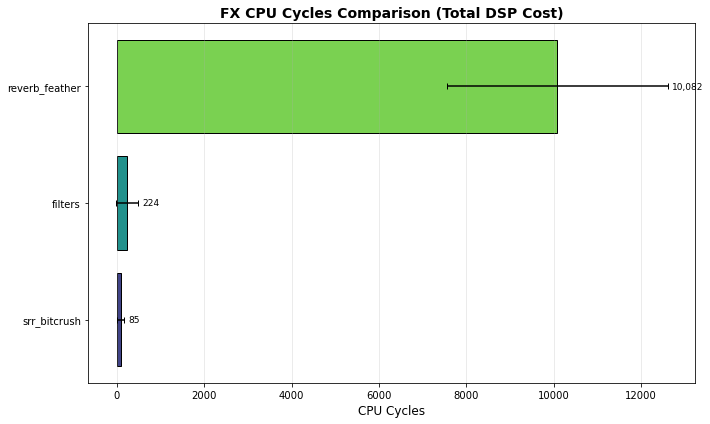

Saved: fx_benchmark_comparison.png


In [322]:
# Bar chart comparing average CPU cycles (using totals only)
fig, ax = plt.subplots(figsize=(10, 6))

fx_means = df_totals.groupby("fx")["cycles"].mean().sort_values(ascending=True)
fx_stds = df_totals.groupby("fx")["cycles"].std().reindex(fx_means.index)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(fx_means)))

bars = ax.barh(
    range(len(fx_means)),
    fx_means,
    xerr=fx_stds,
    color=colors,
    edgecolor="black",
    capsize=3,
)

ax.set_yticks(range(len(fx_means)))
ax.set_yticklabels(fx_means.index)
ax.set_xlabel("CPU Cycles", fontsize=12)
ax.set_title(
    "FX CPU Cycles Comparison (Total DSP Cost)", fontsize=14, fontweight="bold"
)
ax.grid(axis="x", alpha=0.3)

# Add value labels
for i, (cycles, bar) in enumerate(zip(fx_means, bars)):
    ax.text(
        cycles + fx_stds.iloc[i] + 100, i, f"{cycles:,.0f}", va="center", fontsize=9
    )

plt.tight_layout()
plt.savefig(
    "fx_benchmark_comparison.png", dpi=150, bbox_inches="tight", facecolor="white"
)
plt.show()
print("Saved: fx_benchmark_comparison.png")

## Time Series (Optional)

If you collected data over time, this shows how cycle counts vary.

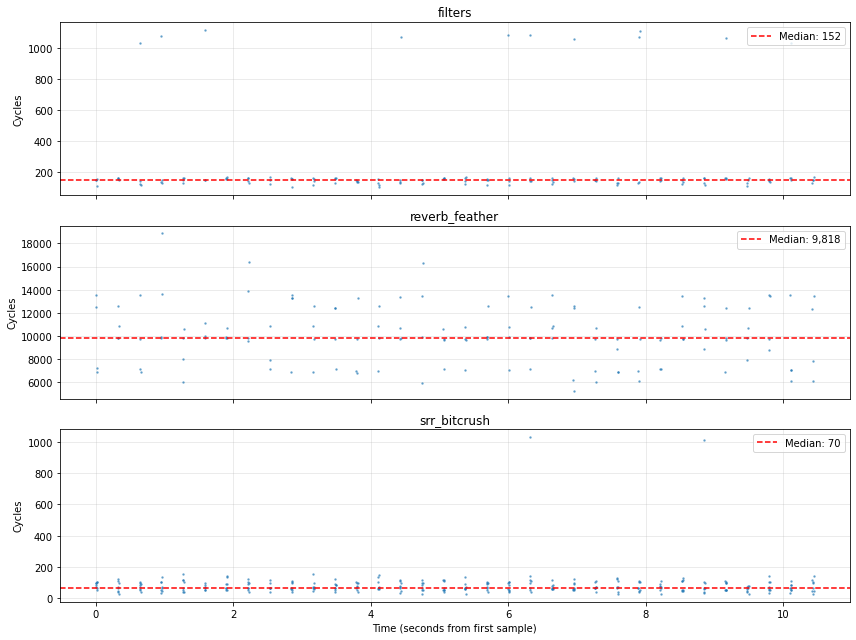

Saved: fx_benchmark_timeseries.png


In [323]:
# Time series plot - cycles over timestamp (using totals only)
if "ts" in df_totals.columns and df_totals["ts"].notna().any():
    fig, axes = plt.subplots(
        len(effects), 1, figsize=(12, 3 * len(effects)), sharex=True
    )
    if len(effects) == 1:
        axes = [axes]

    for ax, fx_name in zip(axes, sorted(effects)):
        fx_data = df_totals[df_totals["fx"] == fx_name].sort_values("ts")

        # Normalize timestamp to seconds from start
        if len(fx_data) > 0:
            t0 = fx_data["ts"].iloc[0]
            time_sec = (fx_data["ts"] - t0) / CPU_FREQ_HZ

            ax.plot(time_sec, fx_data["cycles"], ".", alpha=0.5, markersize=3)
            ax.axhline(
                fx_data["cycles"].median(),
                color="red",
                linestyle="--",
                label=f"Median: {fx_data['cycles'].median():,.0f}",
            )
            ax.set_ylabel("Cycles")
            ax.set_title(fx_name)
            ax.legend(loc="upper right")
            ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Time (seconds from first sample)")
    plt.tight_layout()
    plt.savefig(
        "fx_benchmark_timeseries.png", dpi=150, bbox_inches="tight", facecolor="white"
    )
    plt.show()
    print("Saved: fx_benchmark_timeseries.png")
else:
    print("No timestamp data available for time series plot")

## Analysis by Tags

If effects have tags (like multiband stages: crossover, envelope, recombine), analyze them separately.

In [324]:
# Check if we have tagged data
df_with_tags = df[df["tags"].notna() & (df["tags"] != "")]

if len(df_with_tags) > 0:
    print("Effects with tags:")
    for fx in df_with_tags["fx"].unique():
        fx_tags = df_with_tags[df_with_tags["fx"] == fx]
        print(f"\n{fx}:")
        for tag in fx_tags["tags"].unique():
            tag_data = fx_tags[fx_tags["tags"] == tag]["cycles"]
            print(
                f"  {tag}: {len(tag_data)} samples, median {tag_data.median():,.0f} cycles"
            )
else:
    print("No tagged data found")

No tagged data found


In [325]:
# Bar chart comparing multiband total cycles by crossover config
df_multiband = df[df["fx"] == "multiband"]

if len(df_multiband) > 0 and df_multiband["tags"].notna().any():
    # Extract crossover type from tags (e.g., "total,ap1_6dB" -> "ap1_6dB")
    total_data = df_multiband[
        df_multiband["tags"].str.contains("crossover", na=False)
    ].copy()

    if len(total_data) > 0:
        # Extract crossover config from tag
        total_data["crossover_config"] = total_data["tags"].apply(
            lambda x: x.split(",")[1] if "," in x else x
        )

        # Calculate stats per config
        config_stats = total_data.groupby("crossover_config")["cycles"].agg(
            ["median", "std", "count"]
        )
        config_stats = config_stats.sort_values("median")

        fig, ax = plt.subplots(figsize=(10, 6))

        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(config_stats)))

        bars = ax.barh(
            range(len(config_stats)),
            config_stats["median"],
            xerr=config_stats["std"],
            color=colors,
            edgecolor="black",
            capsize=3,
        )

        ax.set_yticks(range(len(config_stats)))
        ax.set_yticklabels(config_stats.index)
        ax.set_xlabel("CPU Cycles (median)", fontsize=12)
        ax.set_title(
            "Multiband Crossover Cycles by Crossover Config",
            fontsize=14,
            fontweight="bold",
        )
        ax.grid(axis="x", alpha=0.3)

        # Add value labels
        for i, (cycles, bar) in enumerate(zip(config_stats["median"], bars)):
            ax.text(
                cycles + config_stats["std"].iloc[i] + 50,
                i,
                f"{cycles:,.0f}",
                va="center",
                fontsize=9,
            )

        plt.tight_layout()
        plt.savefig(
            "fx_benchmark_multiband_configs.png",
            dpi=150,
            bbox_inches="tight",
            facecolor="white",
        )
        plt.show()
        print("Saved: fx_benchmark_multiband_configs.png")
    else:
        print("No 'crossover' tagged multiband data found")
else:
    print("No multiband data with tags found")

No multiband data with tags found


## Disperser Analysis by Stage Count

The disperser uses cascaded allpass filters. This shows how CPU cost scales with the number of active stages (1-16).

In [326]:
# Scatter plot: disperser cycles by stage count with CI
df_disperser = df[df["fx"] == "disperser"]

if len(df_disperser) > 0 and df_disperser["tags"].notna().any():
    disperser_tagged = df_disperser[df_disperser["tags"].notna()].copy()
    disperser_tagged["stages"] = disperser_tagged["tags"].apply(
        lambda x: int(x[1:]) if x.startswith("s") and x[1:].isdigit() else None
    )
    disperser_tagged = disperser_tagged[disperser_tagged["stages"].notna()]

    if len(disperser_tagged) > 0:
        import scipy.stats as stats

        fig, ax = plt.subplots(figsize=(8, 5))

        # Scatter points
        ax.scatter(
            disperser_tagged["stages"],
            disperser_tagged["cycles"],
            alpha=0.3,
            s=20,
            c="steelblue",
            label="Samples",
        )

        # Linear regression with 95% CI
        x = disperser_tagged["stages"].values
        y = disperser_tagged["cycles"].values
        slope, intercept, r, p, se = stats.linregress(x, y)

        x_fit = np.linspace(1, 32, 100)
        y_fit = slope * x_fit + intercept

        # Confidence interval
        n = len(x)
        y_err = (
            stats.t.ppf(0.975, n - 2)
            * se
            * np.sqrt(1 / n + (x_fit - x.mean()) ** 2 / ((x - x.mean()) ** 2).sum())
        )

        ax.plot(
            x_fit, y_fit, "r-", linewidth=2, label=f"{slope:.0f}x + {intercept:.0f}"
        )
        ax.fill_between(x_fit, y_fit - y_err, y_fit + y_err, alpha=0.2, color="red")

        ax.set_xlabel("Stages", fontsize=12)
        ax.set_ylabel("Cycles", fontsize=12)
        ax.set_title(
            f"Disperser: {slope:.0f} cycles/stage (r²={r**2:.3f})",
            fontsize=13,
            fontweight="bold",
        )
        ax.set_xticks(range(1, 33))
        ax.grid(alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.savefig(
            "fx_benchmark_disperser_stages.png",
            dpi=150,
            bbox_inches="tight",
            facecolor="white",
        )
        plt.show()
else:
    print("No tagged disperser data - run with stage tagging enabled")

No tagged disperser data - run with stage tagging enabled


In [327]:
# Export summary to markdown for documentation
print("\n## Markdown Summary (copy to docs)\n")
print("| Effect | Count | Mean | Median | Std | CPU % |")
print("|--------|-------|------|--------|-----|-------|")
for fx in summary.index:
    row = summary.loc[fx]
    print(
        f"| {fx} | {int(row['count'])} | {row['mean']:,.0f} | {row['median']:,.0f} | {row['std']:,.0f} | {row['cpu_percent']:.2f}% |"
    )


## Markdown Summary (copy to docs)

| Effect | Count | Mean | Median | Std | CPU % |
|--------|-------|------|--------|-----|-------|
| reverb_feather | 134 | 10,082 | 9,818 | 2,526 | 0.87% |
| filters | 134 | 224 | 152 | 256 | 0.02% |
| srr_bitcrush | 268 | 85 | 70 | 86 | 0.01% |


## Disperser Optimization Benchmarks (2025-01)

Manual benchmarks collected during phi-triangle and fast-floor optimization work.

---

### Configuration 1: Baseline (cascade topology, no meta zones, no modulation)

| Stages | Samples | Median Cycles |
|--------|---------|---------------|
| s1     | 105     | 1,065         |
| s8     | 66      | 5,616         |
| s15    | 1       | 10,127        |
| s16    | 304     | 14,332        |
| s32    | 64      | 28,170        |

**Per-stage cost:** ~872 cycles/stage (linear regression)

---

### Configuration 2: Cascade topology + meta zones, no modulation

| Stages | Samples | Median Cycles |
|--------|---------|---------------|
| s32    | 99      | 31,569        |

---

### Configuration 3: Cascade topology + meta zones + modulation

| Stages | Samples | Median Cycles |
|--------|---------|---------------|
| s32    | 105     | 31,274        |

*(Note: slightly lower than no-mod - may need recheck)*

---

### Configuration 4: Bimodal topology + meta zones + modulation

| Stages | Samples | Median Cycles |
|--------|---------|---------------|
| s32    | 96      | 31,692        |

---

### Summary: Meta Zone Overhead (s32)

| Configuration | Median Cycles | Delta from baseline |
|---------------|---------------|---------------------|
| 1. Baseline (cascade, no meta, no mod) | 28,170 | — |
| 2. Cascade + meta, no mod | 31,569 | +3,399 (~12%) |
| 3. Cascade + meta + mod | 31,274 | +3,104 (~11%) |
| 4. Bimodal + meta + mod | 31,692 | +3,522 (~12.5%) |

**Meta zone overhead:** ~3,400 cycles/buffer (phi triangles + coefficient updates)

---

### Optimizations Applied
1. **Fast floor:** Replaced `std::floor` with int truncation in `wrapPhase()` and triangle functions (~40 cycles saved per call)
2. **exp2f:** Replaced `powf(2.0f, x)` with `exp2f(x)` in shaper_buffer.h
3. **Fast fmod:** Branchless floor-based fmod in table_shaper.h
4. **Coefficient stride:** Updates every 4th sample (kCoeffUpdateStride=4)
5. **Delay stability fix:** Delay offset uses base frequency, not detuned frequency